# Integrating the moment equations - Protein

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [3]:
import pickle
import dill # Library that we will use to export lambdify functions

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

# Numerically integrating the moment equations.

In this notebook we will numerically integrate the differential equations for the mRNA distribution moments for the two-state unregulated promoter.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and try to solve them.

# Protein
---
## Importing the steady-state solutions.

Before continuing with the numerical integration of the solutions, let's import the steady state moments analytically derived elsewhere to compare these results with the long-term dynamics.

In [4]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

In [5]:
# Import two-state protein moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'two_state_protein_lambdify.dill', 'rb') as file:
    first_unreg_p = dill.load(file)
    second_unreg_p = dill.load(file)
    third_unreg_p = dill.load(file)
    
# Import two-state protein moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open(tmpdir + 'three_state_protein_lambdify.dill', 'rb') as file:
    first_reg_p = dill.load(file)
    second_reg_p = dill.load(file)
    third_reg_p = dill.load(file)

# Defining the moment equations.

For the mRNA case as we were constructing and testing the code we individually defined functions that computed higher and higher moments. But each new function included the moments from the previous function as all of them depend on each other.

This time we will define a single function that caputes **all** moments that lead to computing the protein third moment $\ee{\bb{p}^3}$. That is the first three moments of the mRNA distribution, the cross correlation terms between protein and mRNA and the three moments of the protein distribution. To have it as a reference let's write down all equations.

### mRNA moments
\begin{align}
% zeroth moment
{d \ee{\bb{m}^0} \over dt}  &= \mathbf{K}_m \left\langle \mathbf{m}^0 \right\rangle.\\
% first moment
{d \ee{\bb{m}^1}\over dt} &= 
\left( \mathbf{K}_m - \mathbf{\Gamma}_m  \right)\ee{\bb{m}^1}
+ \mathbf{R}_m \left\langle \mathbf{m}^0 \right\rangle.\\
% second moment
{d\ee{\bb{m}^2} \over dt} &= \left( \mathbf{K}_m - 2 \mathbf{\Gamma}_m \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}_m + \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}_m
             \left\langle \mathbf{m}^0 \right\rangle\\
% third moment
{d\ee{\bb{m}^3} \over dt} &= \left( \mathbf{K}_m - 3 \mathbf{\Gamma}_m \right) 
             \left\langle \mathbf{m}^3 \right\rangle
             + \left( 3 \mathbf{R}_m + 3 \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}_m - \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}_m
             \left\langle \mathbf{m}^0 \right\rangle            
\end{align}

### Protein moments (and cross correlations)
\begin{align}
% first moment
{d \ee{\bb{p}^1}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_p  \right) \ee{\bb{p}^1}
+ \mathbf{R}_p \left\langle \mathbf{m} \right\rangle.\\
% <mp>
{d \ee{\bb{mp}}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_m -  \mathbf{\Gamma}_p  \right)
\left\langle \mathbf{mp} \right\rangle 
+ \mathbf{R}_m \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \left\langle \mathbf{m}^2 \right\rangle \\
% second moment
{d \ee{\bb{p}^2}\over dt} &=
\left( \mathbf{K} - 2 \mathbf{\Gamma}_p \right) 
\left\langle \mathbf{p}^2 \right\rangle
+ \mathbf{\Gamma}_p \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \mm
+ 2 \mathbf{R}_p \left\langle \mathbf{mp} \right\rangle \\
% <m^2p>
{d \ee{\bb{m}^2\bb{p}}\over dt} &=   
\left( \bb{K} - 2 \bb{\Gamma}_m - \bb{\Gamma}_p \right) 
\ee{\bb{m}^2\bb{p}} +
\bb{R}_m \ee{\bb{p}} +
\left( \bb{R}_m + \bb{\Gamma}_m \right) \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}^3}.\\
% <mp^2>
{d \ee{\bb{m}\bb{p}^2}\over dt} &=   
\left( \bb{K} - \bb{\Gamma}_m - 2 \bb{\Gamma}_p \right)
\ee{\bb{mp}^2} +
\bb{R}_m \ee{\bb{p}^2} +
2 \bb{R}_p \ee{\bb{m}^2\bb{p}} +
\bb{R}_p \ee{\bb{m}^2} +
\bb{\Gamma}_p \ee{\bb{mp}}.\\
% third moment
{d \ee{\bb{p}^3}\over dt} &=
\left( \bb{K} - 3 \bb{\Gamma}_p \right) \ee{\bb{p}^3} +
3 \bb{\Gamma}_p \ee{\bb{p}^2} -
\bb{\Gamma}_p \ee{\bb{p}} +
3 \bb{R}_p \ee{\bb{mp}^2} +
3 \bb{R}_p \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}}.
\end{align}

Let's now implemenet these equations into the function

In [18]:
def dpdt(mp, t, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       
        
    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = mp[0:2]
        m1 = mp[2:4]
        m2 = mp[4:6]
        m3 = mp[6:8]
        p1 = mp[8:10]
        mp1 = mp[10:12]
        p2 = mp[12:14]
        m2p = mp[14:16]
        mp2 = mp[16:18]
        p3 = mp[18::]
    elif Kmat.shape[0] == 3:
        m0 = mp[0:3]
        m1= mp[3:6]
        m2= mp[6:9]
        m3= mp[9:12]
        p1 = mp[12:15]
        mp1 = mp[15:18]
        p2 = mp[18:21]
        m2p = mp[21:24]
        mp2 = mp[24:27]
        p3 = mp[27::]
    
    # Initialize array to save all dynamics
    dmpdt = np.array([])
    
    # Compute the moment equations for the:
    #=== mRNA ===#
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    dmpdt = np.append(dmpdt, dm0dt_eq)
    # <m1>
    dm1dt_eq = np.dot((Kmat - Gm), m1) + np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm1dt_eq)
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
                np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
                np.dot((3 * Rm + 3 * Gm), m2) +\
                np.dot((3 * Rm - Gm), m1) +\
                np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <p1>
    dp1dt_eq = np.dot((Kmat - Gp), p1) + np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp1dt_eq)
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
                np.dot(Rm, p1) +\
                np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
                np.dot(Gp, p1) +\
                np.dot(Rp, m1) +\
                np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
                np.dot(Rm, p1) +\
                np.dot((Rm + Gm), mp1) +\
                np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
                np.dot(Rm, p2) +\
                np.dot((2 * Rp), m2p) +\
                np.dot(Rp, m2) +\
                np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
                np.dot((3 * Gp), p2) -\
                np.dot(Gp, p1) +\
                np.dot((3 * Rp), mp2) +\
                np.dot((3 * Rp), mp1) +\
                np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)
    
    return dmpdt

Let's define a function that will become quite handy in future implementations of these dynamics. This function will take the output of `odeint` function and transform it into a tidy `DataFrame`.

In [102]:
def dynamics_to_df(sol, t):
    '''
    Takes the output of the dpdt function and the vector time and returns
    a tidy pandas DataFrame with the GLOBAL moments.
    Parameters
    ----------
    sol : array-like.
        Array with 20 or 30 columns containing the dynamics of the mRNA and
        protein distribution moments.
    t : array-like.
        Time array used for integrating the differential equations
    Returns
    -------
    tidy dataframe with the GLOBAL moments
    '''
    # Define names of dataframe columns
    names = ['time', 'm1', 'm2', 'm3', 'p1', 'mp', 'p2', 'm2p', 'mp2', 'p3']
    
    # Initialize matrix to save global moments
    mat = np.zeros([len(t), len(names)])
    # Save time array in matrix
    mat[:, 0] = t
    
    # List index for columns depending on number of elements in matrix
    idx = np.arange(int(sol.shape[1]) / 10, sol.shape[1], int(sol.shape[1]) / 10)
    
    # Loop through index and compute global moments
    for i, index in enumerate(idx):
        # Compute and save global moment
        mat[:, i+1] = np.sum(sol[:, int(index):int(index + sol.shape[1] / 10)], 
                           axis=1)
    
    return pd.DataFrame(mat, columns=names)

---

# Two-state promoter
Having defined these functions let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [141]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

kp_on = par_UV5['kp_on']
kp_off = par_UV5['kp_off']
rm = par_UV5['rm']
gm = par_UV5['gm']
gp = par_UV5['gp']
rp = par_UV5['rp']

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [104]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Now we define initial conditions and time array to use for integrating the ODEs

In [105]:
# Define time on which to perform integration
t = np.linspace(0, 60, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation 
mp_sol = sp.integrate.odeint(dpdt, 
                                m0_init + m1_init + m2_init + m3_init +\
                                p1_init + mp_init + p2_init + m2p_init +\
                                mp2_init + p3_init,
                                t,
                                args=(Km_unreg, Rm_unreg, Gm_unreg,
                                      Rp_unreg, Gp_unreg)) 
mp_sol.shape

(201, 20)

Let's test the function converting our ODE numerical integration to a `DataFrame`.

In [106]:
df_sol = dynamics_to_df(mp_sol, t)
df_sol.head().round(1)

,time,m1,m2,m3,p1,mp,p2,m2p,mp2,p3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.3,4.3,36.2,405.1,75.0,603.9,11723.2,5470.1,103341.4,2090697.3
2,0.6,6.8,73.7,1021.0,234.8,2403.3,91597.4,25649.9,972671.1,39266745.9
3,0.9,8.7,108.3,1684.1,452.8,5290.9,301466.1,60540.0,3482998.4,210777272.9
4,1.2,10.1,137.7,2303.1,710.9,9025.1,689141.1,106746.1,8337666.5,675100856.9


For comparison let's compute the *steady-state* values of both the mRNA and the protein levels and save it as a pandas `Series`.

In [107]:
# Define names of dataframe index
names = ['m1', 'm2', 'm3', 'p1', 'p2', 'p3']

# Initialize array to save steady state
mp_ss = np.zeros(len(names))


# Compute mRNA steady state moments
mfunc = [first_unreg_m, second_unreg_m, third_unreg_m]
for i, f in enumerate(mfunc):
    mp_ss[i] = f(kp_on, kp_off, rm, gm)

# Compute the protein steady state moments
pfunc = [first_unreg_p, second_unreg_p, third_unreg_p]
for i, f in enumerate(pfunc):
    mp_ss[i + 3] = f(kp_on, kp_off, rm, gm, rp, gp)

df_ss = pd.Series(mp_ss, index=names)
df_ss

m1    1.400581e+01
m2    2.392858e+02
m3    4.756025e+03
p1    1.400581e+04
p2    2.000841e+08
p3    2.664148e+12
dtype: float64

With this we can now plot the dynamics of all moments normalized by the stead-state value in order to compare the response time of mRNA and protein moments.

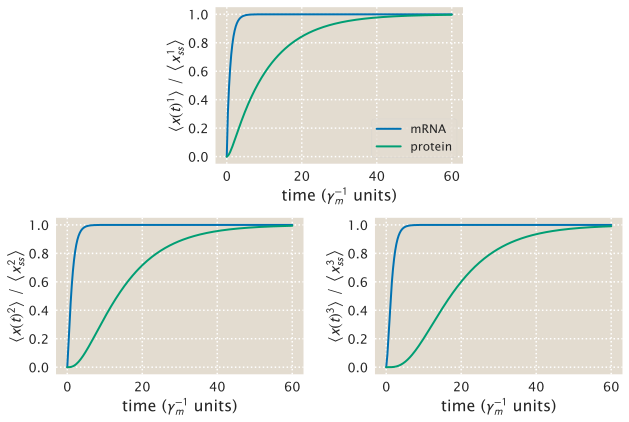

In [108]:
# Initialize figure
fig = plt.figure(figsize=(9, 6))

# Define axis to have two on the bottom and one on the top
ax = list()
ax.append(plt.subplot2grid((2, 4), (0, 1), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 0), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 2), colspan=2, rowspan=1))

# Define array with names of moments to plot
moments_m = ['m1', 'm2', 'm3']
moments_p = ['p1', 'p2', 'p3']

# Loop through groups
for i in range(len(moments_m)):
    # Plot moments moment
    ax[i].plot(df_sol['time'], df_sol[moments_m[i]] / df_ss[moments_m[i]],
              label='mRNA')
    ax[i].plot(df_sol['time'], df_sol[moments_p[i]] / df_ss[moments_p[i]],
              label='protein')
    
    # Label axis
    ax[i].set_xlabel('time ($\gamma_m^{-1}$ units)')
    ax[i].set_ylabel(r'$\left\langle x(t)^{:d} \right\rangle$ / '.format(i+1) +\
                     r'$\left\langle x_{{ss}}^{:d} \right\rangle$'.format(i+1))
    
# Include legend
ax[0].legend(fontsize=12)

plt.tight_layout()
# Save figure
plt.savefig(figdir + 'mp_unreg_dynamics.pdf', bbox_inches='tight')

---

# Three-state promoter

Let's now test the function for the regulated promoter. We need to define the parameters for the regulated promoter.

In [142]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']


kp_on = par_UV5_reg['kp_on']
kp_off = par_UV5_reg['kp_off']
rm = par_UV5_reg['rm']
gm = par_UV5_reg['gm']
ka = par_UV5_reg['ka']
ki = par_UV5_reg['ki']
epsilon = par_UV5_reg['epsilon']
Nns = par_UV5_reg['Nns']

Now we will define the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [143]:
# Define the production matrix
Rm_reg = np.array([[rm, 0, 0],
                   [0, 0, 0],
                   [0, 0, 0]])
# Define the degradation matrix
Gm_reg = np.array([[gm, 0, 0],
                   [0, gm, 0],
                   [0, 0, gm]])

# Define the production matrix
Rp_reg = np.array([[rp, 0, 0],
                   [0, rp, 0],
                   [0, 0, rp]])

# Define the production matrix
Gp_reg = np.array([[gp, 0, 0],
                   [0, gp, 0],
                   [0, 0, gp]])

Let's compute the moments for the $R = 260$ strains and all operators in the absence of inducer.

In [161]:
# Define repressors per cell
rep = 260 
par_UV5_reg['rep'] = rep

# Calculate the repressor on rate including the MWC model
kr_on = k0_norm * rep * chann_cap.p_act(0, ka, ki, epsilon) 
    
# Define energies
operators = ['Oid', 'O1', 'O2', 'O3']
energies = [-17, -15.3, -13.9, -9.7]
energy_dict = dict(zip(operators, energies))

Having defined the parameters that do not depend on the operator let's now loop through operators and integrate the equations. We will also compute the steady-state solution to each of the moments and save it also in a tidy `DataFrame`.

In [174]:
# Define time on which to perform integration
t = np.linspace(0, 200, 1000)

# Define initial conditions
m0_init = [0.3, 0.3, 0.4]
m1_init = [0, 0, 0]
m2_init = [0, 0, 0]
m3_init = [0, 0, 0]
p1_init = [0, 0, 0]
mp_init = [0, 0, 0]
p2_init = [0, 0, 0]
m2p_init = [0, 0, 0]
mp2_init = [0, 0, 0]
p3_init = [0, 0, 0]

# Initialize DataFrame to save the solutions
df_sol_reg = pd.DataFrame() # Dynamics
df_ss_reg = pd.DataFrame() # Steady-state

# Loop through operators integrating the equation at each point
for op in operators:
    eRA = energy_dict[op]
    # Compute the repressor off-rate based on the on-rate and 
    # the binding energy
    kr_off = chann_cap.kr_off_fun(eRA, k0_norm, kp_on, kp_off, Nns)
    
    #=== Compute dynamics ===#
    # Define the rate constant matrix
    Km_reg = np.array([[-kp_off, kp_on, 0], 
                       [kp_off, -(kp_on + kr_on), kr_off],
                       [0, kr_on, -kr_off]])
    # Solve equation 
    sol = sp.integrate.odeint(dpdt, 
                                m0_init + m1_init + m2_init + m3_init +\
                                p1_init + mp_init + p2_init + m2p_init +\
                                mp2_init + p3_init,
                                t,
                                args=(Km_reg, Rm_reg, Gm_reg,
                                      Rp_reg, Gp_reg))  
    # Convert to pandas DataFrame and append the extra information
    df = dynamics_to_df(sol, t)
    df['operator'] = [op] * len(t)
    df['energy'] = [eRA] * len(t)
    df['repressor'] = [rep] * len(t)
    df['IPTG'] = [0] * len(t)
    
    # Append to global data frame
    df_sol_reg = pd.concat([df_sol_reg, df], ignore_index=True)
    
    
    #=== Compute steady-state ===#
    # Define names of dataframe index
    names = ['m1', 'm2', 'm3', 'p1', 'p2', 'p3']

    # Initialize array to save steady state
    mp_ss = np.zeros(len(names))

    # Compute mRNA steady state moments
    mfunc = [first_reg_m, second_reg_m, third_reg_m]
    for i, f in enumerate(mfunc):
        mp_ss[i] = f(kr_on, kr_off, kp_on, kp_off, rm, gm)

    # Compute the protein steady state moments
    pfunc = [first_reg_p, second_reg_p, third_reg_p]
    for i, f in enumerate(pfunc):
        mp_ss[i + 3] = f(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)

    df_ss = pd.Series(mp_ss, index=names)
    df_ss['operator'] = op
    df_ss['energy'] = eRA
    df_ss['repressor'] = rep
    df_ss['IPTG'] = 0
    
    # Append to global data frame
    df_ss_reg = df_ss_reg.append(df_ss, ignore_index=True)
    
df_sol_reg.head().round(1)

,time,m1,m2,m3,p1,mp,p2,m2p,mp2,p3,operator,energy,repressor,IPTG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oid,-17.0,260,0
1,0.2,0.8,5.1,47.3,13.9,79.0,1299.2,605.6,8942.4,140315.9,Oid,-17.0,260,0
2,0.4,0.7,3.6,30.4,27.9,140.1,5609.9,1042.5,37830.2,1433429.2,Oid,-17.0,260,0
3,0.6,0.5,2.6,18.2,39.0,166.1,11359.6,1083.9,67542.3,4394174.8,Oid,-17.0,260,0
4,0.8,0.5,1.8,11.1,47.9,171.3,17447.4,966.0,89026.1,8661286.2,Oid,-17.0,260,0


In [175]:
df_ss_reg.round(1)

,IPTG,energy,m1,m2,m3,operator,p1,p2,p3,repressor
0,0.0,-17.0,0.0,0.1,0.5,Oid,17.2,6575.2,4.473563e+06,260.0
1,0.0,-15.3,0.1,0.4,2.7,O1,93.6,42900.8,3.096138e+07,260.0
2,0.0,-13.9,0.4,1.6,11.7,O2,372.1,273361.5,2.520766e+08,260.0
3,0.0,-9.7,9.0,112.2,1725.9,O3,9038.9,84479685.7,7.407534e+11,260.0


Having this let's plot all moments

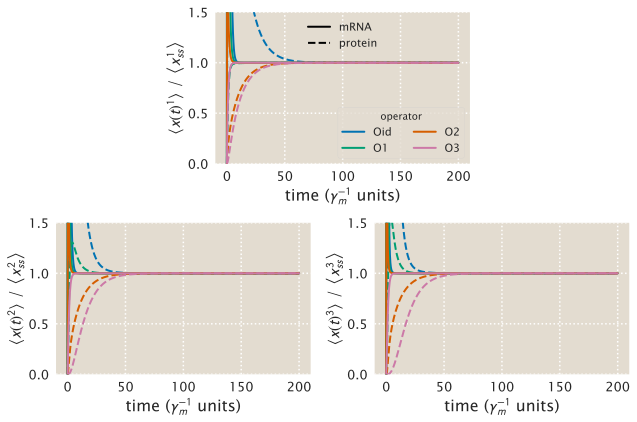

In [182]:
# Initialize figure
fig = plt.figure(figsize=(9, 6))

# Define axis to have two on the bottom and one on the top
ax = list()
ax.append(plt.subplot2grid((2, 4), (0, 1), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 0), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 2), colspan=2, rowspan=1))

# Define array with names of moments to plot
moments_m = ['m1', 'm2', 'm3']
moments_p = ['p1', 'p2', 'p3']

# Define operator colors
colors = sns.color_palette('colorblind', n_colors=len(operators))
color_dict = dict(zip(operators, colors))

# Loop through moments
for i in range(len(moments_m)):
    
    # Loop through operators
    for op in operators:
    # Extract operator data
        data_sol = df_sol_reg[df_sol_reg['operator'] == op]
        data_ss = df_ss_reg[df_ss_reg['operator'] == op]
        # Plot moments moment
        ax[i].plot(data_sol['time'], 
                   data_sol[moments_m[i]] / data_ss[moments_m[i]].values,
                  label=op, color=color_dict[op])
        ax[i].plot(data_sol['time'], 
                   data_sol[moments_p[i]] / data_ss[moments_p[i]].values,
                  label='', color=color_dict[op], linestyle='--')
    
    # Label axis
    ax[i].set_xlabel('time ($\gamma_m^{-1}$ units)')
    ax[i].set_ylabel(r'$\left\langle x(t)^{:d} \right\rangle$ / '.format(i+1) +\
                     r'$\left\langle x_{{ss}}^{:d} \right\rangle$'.format(i+1))
    ax[i].set_ylim([0, 1.5])
    
# Include legend
first_legend = ax[0].legend(loc=0, ncol=2, title='operator')

# Add secondary label to distinguish protein vs mRNA.
ax2 = ax[0].add_artist(first_legend)

# "plot" a solid and a dashed line for the legend
line1, = ax[0].plot([], [], color='black', label='mRNA')
line2, = ax[0].plot([], [], color='black', linestyle='--', label='protein')
# Create another legend.
ax[0].legend(handles=[line1, line2], loc='upper center', frameon=False)

plt.tight_layout()
# Save figure
plt.savefig(figdir + 'mp_reg_dynamics.pdf', bbox_inches='tight')

All dynamics seem to converge to the predicted stteady state. This tells us that the numerical integration of the moment differential equations is working appropietly.